# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>

### <font color=blue><div align="center">29-02-2024</div></font>

## Modules

In [3]:
# Basic modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import random

# Gurobi module
from gurobipy import *

## Data Extraction

In [4]:
# Load the Excel file into a pandas DataFrame


df_21Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=0 , skipfooter=2)
df_22Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=1 , skipfooter=2)
df_23Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=2 , skipfooter=2)
df_24Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=3 , skipfooter=2)
df_30Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=4 , skipfooter=2)
df_05Nov = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=5 , skipfooter=2)
df_07Nov = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=6 , skipfooter=2)


In [5]:
# Display the DataFrame
df = df_21Oct
df

,Numéro du groupe,Femmes,Hommes,WCHR,TransitTime
0,1,NaN,1.0,NaN,01:15:00
1,2,1.0,NaN,NaN,00:00:00
2,3,NaN,1.0,NaN,00:00:00
3,4,1.0,NaN,NaN,00:00:00
4,5,NaN,2.0,NaN,05:25:00
...,...,...,...,...,...
106,107,1.0,NaN,NaN,03:30:00
107,108,2.0,NaN,NaN,05:25:00
108,109,2.0,NaN,NaN,05:25:00
109,110,2.0,NaN,NaN,01:35:00


The code in the cells below creates a dictionary Passengers defined as follows:

- Passengers Keys: IDs of passengers.
- Passengers Items: For each ID in Passengers, we specify its *type* (female: 0, male: 1, disabled: 2), its *group number*, and its *transit time*.

Notice that for passengers with a transit time equal to 0 or larger than 2 hours, the transit time in the dictionary is set to $\infty$


In [6]:
def convert_TransitTime(time_val):

    # Convert time to minutes
    total_minutes = time_val.hour * 60 + time_val.minute
    
    # Check if total minutes is greater than 2 hours or equal to 0
    if total_minutes > 120 or total_minutes == 0:
        return float('inf')  # Return infinity
    else:
        return total_minutes

df['TransitTime'] = df['TransitTime'].apply(convert_TransitTime)

In [7]:
# Create Passengers dictionary
Passengers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0

transit_times = set()

# Groups : dict[int : List[int]]

Passengers = dict()
i = 1

for group in df.itertuples():
    if not pd.isna(group[2]):
        for k in range(int(group[2])):
            Passengers[i] = {'type': 0, 'group':group[1], 'transit':group[5]}
            number_f += 1
            transit_times.add(group[5])
            i+=1
    if not pd.isna(group[3]):
        for k in range(int(group[3])):
            Passengers[i] = {'type': 1, 'group':group[1], 'transit':group[5]}
            number_m += 1
            transit_times.add(group[5])
            i+=1
    if not pd.isna(group[4]):
        for k in range(int(group[4])):
            Passengers[i] = {'type': 2, 'group':group[1], 'transit':group[5]}
            number_d += 1
            transit_times.add(group[5])
            i+=1
    
    
Passengers 

{1: {'type': 1, 'group': 1, 'transit': 75.0},
 2: {'type': 0, 'group': 2, 'transit': inf},
 3: {'type': 1, 'group': 3, 'transit': inf},
 4: {'type': 0, 'group': 4, 'transit': inf},
 5: {'type': 1, 'group': 5, 'transit': inf},
 6: {'type': 1, 'group': 5, 'transit': inf},
 7: {'type': 0, 'group': 6, 'transit': inf},
 8: {'type': 0, 'group': 7, 'transit': inf},
 9: {'type': 0, 'group': 8, 'transit': 80.0},
 10: {'type': 1, 'group': 8, 'transit': 80.0},
 11: {'type': 1, 'group': 9, 'transit': inf},
 12: {'type': 0, 'group': 10, 'transit': inf},
 13: {'type': 0, 'group': 11, 'transit': inf},
 14: {'type': 1, 'group': 11, 'transit': inf},
 15: {'type': 1, 'group': 12, 'transit': 70.0},
 16: {'type': 1, 'group': 13, 'transit': inf},
 17: {'type': 0, 'group': 14, 'transit': inf},
 18: {'type': 1, 'group': 14, 'transit': inf},
 19: {'type': 1, 'group': 15, 'transit': inf},
 20: {'type': 1, 'group': 16, 'transit': 95.0},
 21: {'type': 0, 'group': 17, 'transit': 60.0},
 22: {'type': 1, 'group': 1

We define a dictionnary *Groups*, containing as keys the group ID and as valuea, the list of the members of the group

In [8]:
Groups = dict()

print(Passengers)

for i, passager in Passengers.items():

    if passager['group'] in Groups:
        Groups[passager['group']].append(i)
    else :
        Groups[passager['group']] = [i]

Keys = list(Groups.keys()).copy()


for i in Keys:
        if len(Groups[i]) ==1: del(Groups[i])
Groups

{1: {'type': 1, 'group': 1, 'transit': 75.0}, 2: {'type': 0, 'group': 2, 'transit': inf}, 3: {'type': 1, 'group': 3, 'transit': inf}, 4: {'type': 0, 'group': 4, 'transit': inf}, 5: {'type': 1, 'group': 5, 'transit': inf}, 6: {'type': 1, 'group': 5, 'transit': inf}, 7: {'type': 0, 'group': 6, 'transit': inf}, 8: {'type': 0, 'group': 7, 'transit': inf}, 9: {'type': 0, 'group': 8, 'transit': 80.0}, 10: {'type': 1, 'group': 8, 'transit': 80.0}, 11: {'type': 1, 'group': 9, 'transit': inf}, 12: {'type': 0, 'group': 10, 'transit': inf}, 13: {'type': 0, 'group': 11, 'transit': inf}, 14: {'type': 1, 'group': 11, 'transit': inf}, 15: {'type': 1, 'group': 12, 'transit': 70.0}, 16: {'type': 1, 'group': 13, 'transit': inf}, 17: {'type': 0, 'group': 14, 'transit': inf}, 18: {'type': 1, 'group': 14, 'transit': inf}, 19: {'type': 1, 'group': 15, 'transit': inf}, 20: {'type': 1, 'group': 16, 'transit': 95.0}, 21: {'type': 0, 'group': 17, 'transit': 60.0}, 22: {'type': 1, 'group': 17, 'transit': 60.0}, 

{5: [5, 6],
 8: [9, 10],
 11: [13, 14],
 14: [17, 18],
 17: [21, 22],
 19: [24, 25, 26, 27],
 20: [28, 29, 30, 31],
 21: [32, 33],
 23: [35, 36],
 24: [37, 38],
 27: [41, 42],
 31: [46, 47],
 34: [50, 51],
 35: [52, 53],
 39: [57, 58],
 45: [64, 65],
 51: [71, 72],
 55: [76, 77],
 56: [78, 79],
 57: [80, 81],
 59: [83, 84],
 61: [86, 87],
 63: [89, 90],
 65: [92, 93, 94],
 68: [97, 98],
 71: [101, 102],
 77: [108, 109],
 87: [119, 120],
 92: [125, 126],
 95: [129, 130],
 103: [138, 139],
 104: [140, 141],
 108: [145, 146],
 109: [147, 148],
 110: [149, 150]}

Definition of parameters necessary for the following steps

In [9]:
weight_f = 70
weight_m = 85
weight_d = 92.5

if sum([4*number_d,number_f,number_m]) <= 174 :
    number_of_rows = 29 #Aircraft model A320
else :
    number_of_rows = 35 #Aircraft model A321

number_of_columns = 7 # adding the aisle


## Model

Defining the relevant variables of the problem

The binary variables $AssignmentVarDict_{i,j,k}$ specify whether the seat located at position $(i,j)$ is occupied by passenger $k$.

In [10]:

m = Model("Seats_Allocation")

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns + 1)
                    for k in range(1, len(Passengers)+1)}

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-04


The integer variables $i_{\text{min}}[g]$ and $i_{\text{max}}[g]$ (resp. $j_{\text{min}}[g]$ and $j_{\text{max}}[g]$) give the value
of $i$ (resp. the value of $j$) that is the smallest and the largest \
in group $g$


In [11]:

# Variables i_{min}, i_{max}, j_{min} et j_{max}
i_min = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_rows , name=f'i_min({g})') 
            for g in Groups.keys()}

i_max = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_rows , name=f'i_max({g})') 
            for g in Groups.keys()}

j_min = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_columns , name=f'j_min({g})') 
            for g in Groups.keys()}

j_max = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_columns  , name=f'j_max({g})') 
            for g in Groups.keys()}


### The constraints 

- Constraints related to the definition of variables $i_{\text{min}}[g]$, $i_{\text{max}}[g]$, $j_{\text{min}}[g]$, $j_{\text{max}}[g]$

In [12]:


i_min_Passagers_Group = {(g,p) : m.addConstr(i_min[g] <= quicksum([i*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'i_min_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

i_max_Passagers_Group = {(g,p) : m.addConstr(i_max[g] >= quicksum([i*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'i_max_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

j_min_Passagers_Group = {(g,p) : m.addConstr(j_min[g] <= quicksum([j*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'j_min_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

j_max_Passagers_Group = {(g,p) : m.addConstr(j_max[g] >= quicksum([j*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'j_max_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }


- Every person has one seat

In [13]:
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                                for i in range(1, number_of_rows + 1)
                                                for j in range(1, number_of_columns + 1) ])
                                                == 1)
                                                for k in range(1,len(Passengers)+1) }

- Every seat is allocated to a single person

In [14]:
ALLOCATIONCONSTDIC = { (i,j) : m.addConstr(quicksum([AssignmenVarDict[(i,j,k)]
                                                     for k in range(1, len(Passengers)+1)])
                                                     <=1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns+1) }

- Aisle seats are always free

In [15]:
AISLECONSTDIC = { i : m.addConstr(quicksum([AssignmenVarDict[(i,4,k)]
                                                     for k in range(1, len(Passengers)+1)])
                                                     == 0)
                                                     for i in range(1, number_of_rows + 1)   
}

- Barycenter constraint

In [16]:
i_m = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

i_f = quicksum([weight_f * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

i_d = quicksum([weight_d * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

i_bary = (i_m + i_f +i_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)


j_m = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

j_f = quicksum([weight_f * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

j_d = quicksum([weight_d * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

j_bary = (j_m + j_f + j_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

In [17]:
IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 5)
JMINBARYCONST = m.addConstr(3 <= j_bary )

- A disabeled person has 4 seats on the aisle side

In [18]:

SeatPer_WCHR_CONST = {k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)] 
                                               for i in range(1, number_of_rows ) 
                                               for j in [3, 6] 
                                               ]) == 1, name=f"SeatPerWCHR{k}")
                                               for k in range(1, len(Passengers) + 1)
                                               if Passengers[k]['type'] == 2}

for k in range(1, len(Passengers) + 1):
    if Passengers[k]['type'] == 2:
        for i in range(1, number_of_rows):
            for j in [3, 6]:
                m.addConstr(AssignmenVarDict[(i, j, k)] + quicksum(
                      [AssignmenVarDict[(i, j - 1, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i}_{j-1}')
                
                m.addConstr(AssignmenVarDict[(i, j, k)] +quicksum(
                      [AssignmenVarDict[(i+1, j, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i+1}_{j}')
                m.addConstr(AssignmenVarDict[(i, j, k)]+ quicksum(
                      [AssignmenVarDict[(i+1, j - 1, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1,  
                            name=f'Neighbor_WCHR{k}_{i+1}_{j-1}')

## Time Objectif

- Transit time

In [19]:
transit_obj = quicksum( [ AssignmenVarDict[(i,j,k)]* i*(1/Passengers[k]['transit'])
                      for i in range(1, number_of_rows+1)
                      for j in range(1, number_of_columns+1 )
                      for k in range(1, len(Passengers)+1)
                      if Passengers[k]['transit'] != float('inf') ])

m.setObjective(transit_obj, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()

## Optimisation

In [20]:
m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




                                                   z* = 4.07                                                    



In [21]:
z_old = round(transit_obj.getValue(), 2)

- Transit time visualization

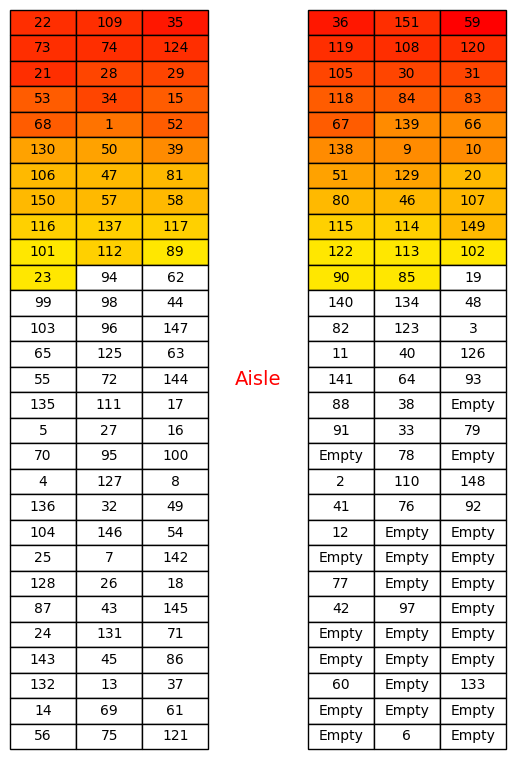

In [22]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passengers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passengers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passengers[k]['transit']]


def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Grouping Objectif

In [23]:

obj_grouping = quicksum([10*(i_max[g] - i_min[g]) + (j_max[g] - j_min[g])
                        for g in Groups.keys()])

m.setObjective(obj_grouping, GRB.MINIMIZE)

m.params.outputflag = 1

m.update()

Set parameter OutputFlag to value 1


## Optimisation


In [24]:
# Set iteration limit
m.setParam(GRB.Param.TimeLimit, 100)  # Change to the desired iteration limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




Set parameter TimeLimit to value 100
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 687 rows, 30793 columns and 249497 nonzeros
Model fingerprint: 0xd958aa8a
Variable types: 0 continuous, 30793 integer (30653 binary)
Coefficient statistics:
  Matrix range     [6e-03, 3e+01]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]

Loaded MIP start from previous solve with objective 10010

Presolve removed 59 rows and 4379 columns
Presolve time: 0.62s
Presolved: 628 rows, 26414 columns, 172429 nonzeros
Variable types: 0 continuous, 26414 integer (26274 binary)
Found heuristic solution: objective 1160.0000000

Root relaxation: objective 2.482459e-13, 1442 iterations, 0.19 seconds (0.14 work units)

    Nodes    |    Current Node 

- Grouping visualisation

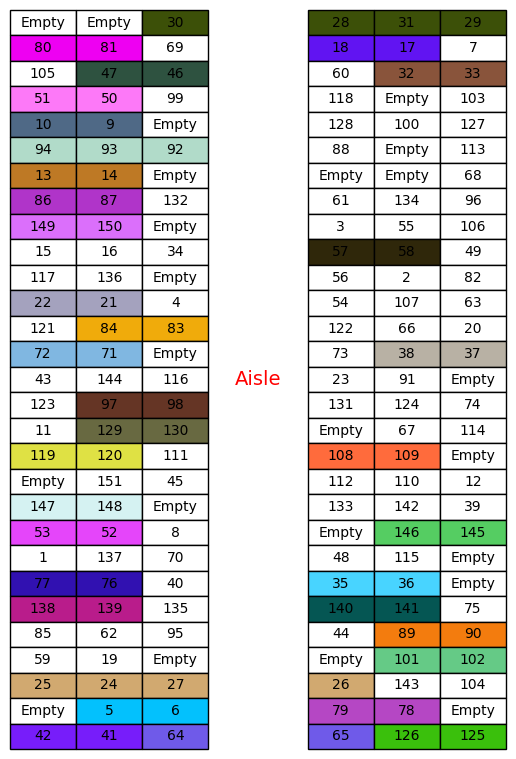

In [25]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }


data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
                else:
                    data2[i-1][j-5] = k
                    if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

                    
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Coupling both objectives

In [26]:
m.setObjective(0.7*obj_grouping + 0.3*transit_obj, GRB.MINIMIZE)

m.params.outputflag = 1

m.update()

## Optimisation

In [27]:
# Set iteration limit
m.setParam(GRB.Param.TimeLimit, 100)  # Change to the desired iteration limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 687 rows, 30793 columns and 249497 nonzeros
Model fingerprint: 0x8281652a
Variable types: 0 continuous, 30793 integer (30653 binary)
Coefficient statistics:
  Matrix range     [6e-03, 3e+01]
  Objective range  [3e-03, 7e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]

Loaded MIP start from previous solve with objective 33.4358

Presolve removed 59 rows and 4379 columns
Presolve time: 0.47s
Presolved: 628 rows, 26414 columns, 172429 nonzeros
Variable types: 0 continuous, 26414 integer (26274 binary)
Found heuristic solution: objective 32.8496189

Root relaxation: objective 1.221447e+00, 2669 iterations, 0.19 seconds (0.22 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     

- Transit time visualisation

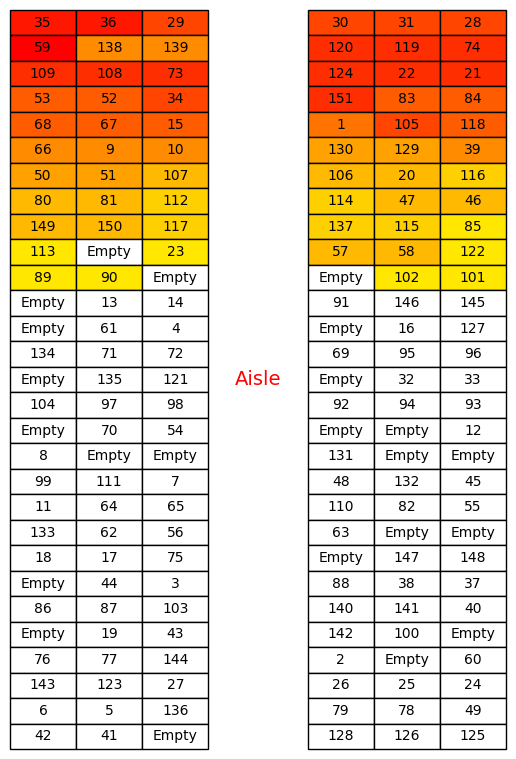

In [28]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passengers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passengers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passengers[k]['transit']]


def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Disabled visualization

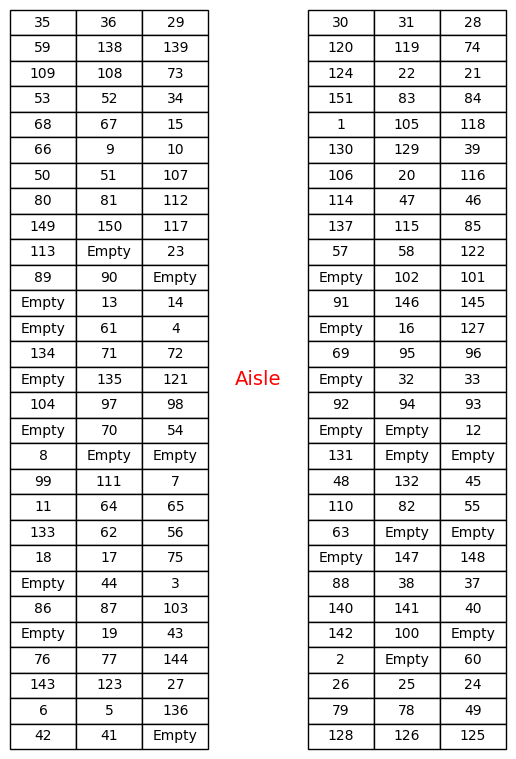

In [29]:

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['type']==2 :
                        colors1[i-1][j-1] = '#800080'
                        colors1[i-1][j-2] = '#800080'
                        colors1[i][j-1] = '#800080'
                        colors1[i][j-2] = '#800080'
                elif j>4:
                    data2[i-1][j-5] = k
                    if Passengers[k]['type']==2:
                        colors2[i-1][j-5] = '#800080'
                        colors2[i-1][j-6] = '#800080'
                        colors2[i][j-5] = '#800080'
                        colors2[i][j-6] = '#800080'

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Groups vizualisation

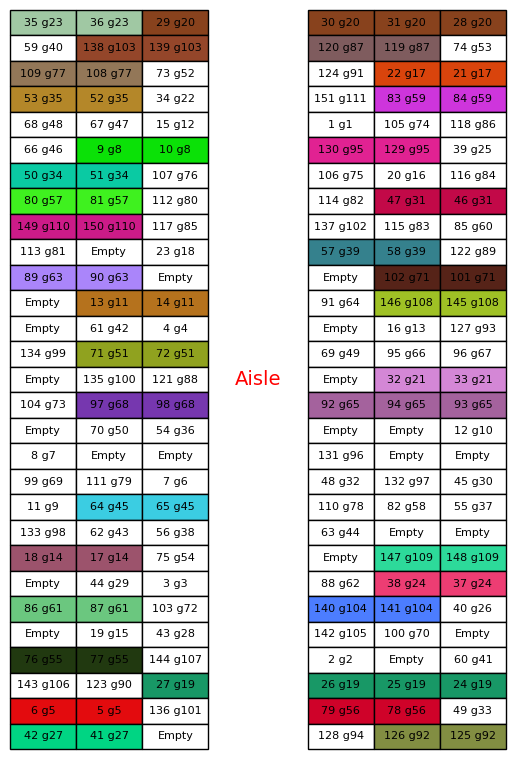

In [30]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }


data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = f"{k} g{Passengers[k]['group']}"
                    if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
                else:
                    data2[i-1][j-5] = f"{k} g{Passengers[k]['group']}"
                    if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

                    
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Metrics

- Transit metric

In [31]:

z_new = round(transit_obj.getValue(), 2)


print("The satisfaction level related to transit time:", (1- (z_new- z_old)/z_old) * 100, " %" )

The satisfaction level related to transit time: 98.77149877149878  %


- Grouping metric

In [32]:
# Définition des constantes pour les niveaux de satisfaction
SATISFIED = 1.0
MEDIUM_SATISFIED = 0.5
NOT_SATISFIED = 0.0

# Initialisation des variables pour les scores de satisfaction
satisfaction_scores = []

for group, passengers in Groups.items():
    print(passengers)
    for pass_id in passengers:
        seat_positions = [(i, j) for i in range(1, number_of_rows+1)
                            for j in range(1, number_of_columns+1)
                            if AssignmenVarDict.get((i, j, pass_id), 0).x == 1]
        if seat_positions:  # Vérifie si la liste n'est pas vide
            seat_position = seat_positions[0]  # Prend le premier élément
            print(f"** Le passager {pass_id} est assis à la position {seat_position}")
        else:
            print(f"Aucun siège trouvé pour le passager {pass_id}. Vérifiez l'indexation et les données.")
            
        i, j = seat_position
        neighbors = [(i, j-1), (i, j+1)]
        satisfaction = 0
        for neighbor in neighbors:
            ni, nj = neighbor
            if 1 <= nj <= number_of_columns:
                if nj == 4 or j == 4:  # S'ils sont séparés par l'allée, attribuez MEDIUM_SATISFIED seulement si dans la même rangée
                    if any(AssignmenVarDict.get((ni, nj, other_pass_id), 0).x == 1 for other_pass_id in passengers if other_pass_id != pass_id):
                        print(f"Pass {pass_id}, Seat {i, j}, Neighbor {neighbor}, Medium")
                        satisfaction = max(satisfaction, MEDIUM_SATISFIED)
                elif nj != 4:
                    if any(AssignmenVarDict.get((ni, nj, other_pass_id), 0).x == 1 for other_pass_id in passengers if (other_pass_id != pass_id and ni == i)):
                        print(f"Pass {pass_id}, Seat {i, j}, Neighbor {neighbor}, True")
                        satisfaction = max(satisfaction, SATISFIED)
                    else :
                        print(f"Pass {pass_id}, Seat {i, j}, Neighbor {neighbor}, False")
                        satisfaction = max(satisfaction, NOT_SATISFIED)
        satisfaction_scores.append(satisfaction)
        print(f"** Passager {pass_id} -- satisfaction {satisfaction}\n")

for pass_id in range(1, len(Passengers) + 1):
    if all(pass_id not in passengers for _, passengers in Groups.items()):
        # Ce passager est seul
        # print(f"Le passager {pass_id} est seul et est automatiquement SATISFIED.")
        satisfaction_scores.append(SATISFIED)

# Calcul du score de groupement moyen (pourcentage de satisfaction)
grouping_score = sum(satisfaction_scores) / len(satisfaction_scores)

# Retourner le score de groupement en pourcentage
grouping_score_percentage = grouping_score * 100
grouping_score_percentage


[5, 6]
** Le passager 5 est assis à la position (28, 2)
Pass 5, Seat (28, 2), Neighbor (28, 1), True
Pass 5, Seat (28, 2), Neighbor (28, 3), False
** Passager 5 -- satisfaction 1.0

** Le passager 6 est assis à la position (28, 1)
Pass 6, Seat (28, 1), Neighbor (28, 2), True
** Passager 6 -- satisfaction 1.0

[9, 10]
** Le passager 9 est assis à la position (6, 2)
Pass 9, Seat (6, 2), Neighbor (6, 1), False
Pass 9, Seat (6, 2), Neighbor (6, 3), True
** Passager 9 -- satisfaction 1.0

** Le passager 10 est assis à la position (6, 3)
Pass 10, Seat (6, 3), Neighbor (6, 2), True
** Passager 10 -- satisfaction 1.0

[13, 14]
** Le passager 13 est assis à la position (12, 2)
Pass 13, Seat (12, 2), Neighbor (12, 1), False
Pass 13, Seat (12, 2), Neighbor (12, 3), True
** Passager 13 -- satisfaction 1.0

** Le passager 14 est assis à la position (12, 3)
Pass 14, Seat (12, 3), Neighbor (12, 2), True
** Passager 14 -- satisfaction 1.0

[17, 18]
** Le passager 17 est assis à la position (22, 2)
Pas

98.67549668874173

## Partie Dynamique

In [61]:
AllGroups = dict()

print(Passengers)

for i, passager in Passengers.items():
    if passager['group'] in AllGroups:
        AllGroups[passager['group']].append(i)
    else :
        AllGroups[passager['group']] = [i]



{1: {'type': 1, 'group': 1, 'transit': 75.0}, 2: {'type': 0, 'group': 2, 'transit': inf}, 3: {'type': 1, 'group': 3, 'transit': inf}, 4: {'type': 0, 'group': 4, 'transit': inf}, 5: {'type': 1, 'group': 5, 'transit': inf}, 6: {'type': 1, 'group': 5, 'transit': inf}, 7: {'type': 0, 'group': 6, 'transit': inf}, 8: {'type': 0, 'group': 7, 'transit': inf}, 9: {'type': 0, 'group': 8, 'transit': 80.0}, 10: {'type': 1, 'group': 8, 'transit': 80.0}, 11: {'type': 1, 'group': 9, 'transit': inf}, 12: {'type': 0, 'group': 10, 'transit': inf}, 13: {'type': 0, 'group': 11, 'transit': inf}, 14: {'type': 1, 'group': 11, 'transit': inf}, 15: {'type': 1, 'group': 12, 'transit': 70.0}, 16: {'type': 1, 'group': 13, 'transit': inf}, 17: {'type': 0, 'group': 14, 'transit': inf}, 18: {'type': 1, 'group': 14, 'transit': inf}, 19: {'type': 1, 'group': 15, 'transit': inf}, 20: {'type': 1, 'group': 16, 'transit': 95.0}, 21: {'type': 0, 'group': 17, 'transit': 60.0}, 22: {'type': 1, 'group': 17, 'transit': 60.0}, 

In [106]:
import random

# print(Groups)

def shuffle_groups(group_list, proportion):
    group_list = list(group_list)
    # Mélanger la liste de groupes de manière aléatoire
    random.shuffle(group_list)
    
    # Calculer le nombre de groupes à sélectionner
    num_selected = int(len(group_list) * proportion)
    
    # Sélectionner les groupes en fonction de la proportion spécifiée
    selected_groups = dict(group_list[:num_selected])

    return selected_groups


# Appel de la fonction shuffle_groups avec une proportion de 0.5 (50%) de groupes qui veulent changer
groupes_selectionnes = shuffle_groups(AllGroups.items(), proportion=0.7)

print(groupes_selectionnes)
# Affichage des groupes sélectionnés de manière aléatoire
print("Groupes sélectionnés de manière aléatoire:")
for group, choices in groupes_selectionnes.items():
    print(f"Groupe: {group}, Passagers possibles: {choices}")

{57: [80, 81], 21: [32, 33], 63: [89, 90], 40: [59], 16: [20], 111: [151], 39: [57, 58], 93: [127], 73: [104], 7: [8], 54: [75], 109: [147, 148], 28: [43], 88: [121], 108: [145, 146], 100: [135], 24: [37, 38], 67: [96], 4: [4], 85: [117], 89: [122], 99: [134], 110: [149, 150], 36: [54], 91: [124], 22: [34], 60: [85], 48: [68], 96: [131], 55: [76, 77], 66: [95], 101: [136], 106: [143], 95: [129, 130], 52: [73], 11: [13, 14], 49: [69], 74: [105], 107: [144], 20: [28, 29, 30, 31], 23: [35, 36], 26: [40], 78: [110], 42: [61], 64: [91], 13: [16], 62: [88], 6: [7], 59: [83, 84], 44: [63], 35: [52, 53], 79: [111], 71: [101, 102], 77: [108, 109], 17: [21, 22], 31: [46, 47], 8: [9, 10], 2: [2], 46: [66], 98: [133], 37: [55], 25: [39], 68: [97, 98], 72: [103], 9: [11], 56: [78, 79], 47: [67], 53: [74], 50: [70], 69: [99], 5: [5, 6], 76: [107], 103: [138, 139], 15: [19], 92: [125, 126], 38: [56], 75: [106]}
Groupes sélectionnés de manière aléatoire:
Groupe: 57, Passagers possibles: [80, 81]
Group

In [107]:
def assign_permutable_groups(groups, selected_groups):
    assigned_groups = {}
    permutation_candidates = {}

    for selected_group, selected_choices in selected_groups.items():
        
        # Initialiser une liste vide pour stocker les groupes compatibles
        compatible_groups = []
        
        # Parcourir les groupes de `groups` pour trouver les groupes compatibles pour permutation
        for group, choices in groups.items():
            # On vérifie que les groupes sont de même taille (len) et qu'ils ont le même poids (pour vérifier la contrainte de barycentre).
            # if len(selected_choices) == len(choices) and sum(Passengers[k]['type'] for k in selected_choices) == sum(Passengers[k]['type'] for k in choices):
            if len(selected_choices) == len(choices):
                compatible_groups.append(group)
        
        # Associer la liste des groupes compatibles au groupe sélectionné dans le dictionnaire permutation_candidates
        permutation_candidates[selected_group] = compatible_groups
    
    return permutation_candidates

# Attribution des groupes associés pour permutation
groupes_assignes = assign_permutable_groups(AllGroups, groupes_selectionnes)

print(groupes_assignes)

# Affichage des groupes sélectionnés et de leurs groupes associés pour permutation
print("Groupes sélectionnés et leurs groupes associés pour permutation:")
for selected_group, assigned_groups in groupes_assignes.items():
    print(f"Groupe sélectionné: {selected_group}, Groupes associés pour permutation:")
    for group in assigned_groups:
        print(f"    {group}: {AllGroups[group]}")

{57: [5, 8, 11, 14, 17, 21, 23, 24, 27, 31, 34, 35, 39, 45, 51, 55, 56, 57, 59, 61, 63, 68, 71, 77, 87, 92, 95, 103, 104, 108, 109, 110], 21: [5, 8, 11, 14, 17, 21, 23, 24, 27, 31, 34, 35, 39, 45, 51, 55, 56, 57, 59, 61, 63, 68, 71, 77, 87, 92, 95, 103, 104, 108, 109, 110], 63: [5, 8, 11, 14, 17, 21, 23, 24, 27, 31, 34, 35, 39, 45, 51, 55, 56, 57, 59, 61, 63, 68, 71, 77, 87, 92, 95, 103, 104, 108, 109, 110], 40: [2, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 18, 22, 25, 26, 28, 29, 30, 32, 33, 36, 37, 38, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 53, 54, 58, 60, 62, 64, 66, 67, 69, 70, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 93, 94, 96, 97, 98, 99, 100, 101, 102, 105, 106, 107, 111], 16: [2, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 18, 22, 25, 26, 28, 29, 30, 32, 33, 36, 37, 38, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 53, 54, 58, 60, 62, 64, 66, 67, 69, 70, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 93, 94, 96, 97, 98, 99, 100, 101, 

In [155]:
from random import choice

# On a implémenté deux fonction random ou choice. La première permet de sélection aléatoirement le nombre de groupes (ou personnes seules) sur lequel on va effectuer les permutations. (shuffle)
# Puis on permute à l'intérieur de ces groupes sélectionnés aléatoirement.
# Enfin, la boucle ci-dessous, permet de sélectionner aléatoirement des permutations parmis toutes les permutations possibles pour chacun des groupes. (fonction choice de random)

groupes_used = []
selected_permutations = {}
groupes_update = {}
selected_group_used = []
metrique_choix = 0
metrique_tot = 0

for group, permutations in groupes_assignes.items():
    # Copier les permutations dans groupes_update
    groupes_update[group] = permutations.copy()

    # Filtrer pour ne pas sélectionner le groupe lui-même si présent
    possible_permutations = [g for g in permutations if g != group]

    if possible_permutations and group not in groupes_used:
        # Sélection aléatoire d'un groupe permutable
        selected_group = choice(possible_permutations)
        selected_permutations[group] = selected_group
        groupes_used.append(group)
        selected_group_used.append(selected_group)

        # Mettre à jour groupes_update pour chaque groupe avec les groupes sélectionnés retirés
        # Métrique Proportionnelle aux choix possibles :
        for g in groupes_used:
            groupes_update[g] = [perm for perm in groupes_update[g] if perm not in selected_group_used]

            metrique_choix += len(groupes_update[g])
            metrique_tot += len(groupes_assignes[g])
            print("metrique choix", metrique_choix/metrique_tot)


# Exemple de structure pour les assignations post-traitement
# Supposons que cela représente le résultat final où '1' indique une assignation
post_processing_assignments = {(i, j, pass_id): AssignmenVarDict.get((i, j, pass_id), 0).x 
                                for (i, j, pass_id) in AssignmenVarDict}


# On permute

# Effectuer les permutations basées sur les résultats de Gurobi
for group, perm_group in selected_permutations.items():
    group_passengers = AllGroups[group]
    perm_group_passengers = AllGroups[perm_group]
    
    for gp, pgp in zip(group_passengers, perm_group_passengers):
        for i in range(1, number_of_rows + 1):
            for j in range(1, number_of_columns + 1):
                key_gp = (i, j, gp)
                key_pgp = (i, j, pgp)
                
                # Vérifier si gp est assigné à ce siège, puis échanger les assignations
                if post_processing_assignments.get(key_gp, 0) == 1:
                    # Échanger les assignations
                    post_processing_assignments[key_gp] = 0
                    post_processing_assignments[key_pgp] = 1


# Après la permutation, recalculer le score de satisfaction
satisfaction_scores = []

for _, passengers in AllGroups.items():
    for pass_id in passengers:
        seat_positions = [(i, j) for i in range(1, number_of_rows+1)
                          for j in range(1, number_of_columns+1)
                          if post_processing_assignments.get((i, j, pass_id), 0) == 1]

        if seat_positions:
            i, j = seat_positions[0]  # Position du siège du passager actuel
        else:
            continue  # Suppose une assignation valide pour simplifier
        
        neighbors = [(i, j-1), (i, j+1)]  # Déterminer les sièges voisins
        satisfaction = 0
        for neighbor in neighbors:
            ni, nj = neighbor
            if 1 <= nj <= number_of_columns:
                if nj == 4 or j == 4:  # Si séparés par l'allée, vérifier pour MEDIUM_SATISFIED
                    if any(post_processing_assignments.get((ni, nj, other_pass_id), 0) == 1 for other_pass_id in passengers if other_pass_id != pass_id):
                        satisfaction = max(satisfaction, MEDIUM_SATISFIED)
                elif nj != 4:  # Pour les sièges non séparés par l'allée
                    if any(post_processing_assignments.get((ni, nj, other_pass_id), 0) == 1 for other_pass_id in passengers if other_pass_id != pass_id and ni == i):
                        satisfaction = max(satisfaction, SATISFIED)
                    else:
                        satisfaction = max(satisfaction, NOT_SATISFIED)
        satisfaction_scores.append(satisfaction)

# Rajouter deux scores de satisfactions (l'un proportionnel au nombre de choix possibles, et l'autre proportionnel au rang d'arrivée dans la liste d'attente);
# On pourra éventuellement mettre de poids pour pondérer le modèle.


# Calcul du nouveau score de satisfaction moyen
new_grouping_score_percentage = ((sum(satisfaction_scores) / len(satisfaction_scores)) + metrique_choix/metrique_tot)* 100/2
new_grouping_score_percentage

metrique choix 0.96875
metrique choix 0.953125
metrique choix 0.9479166666666666
metrique choix 0.9375
metrique choix 0.93125
metrique choix 0.9270833333333334
metrique choix 0.9241071428571429
metrique choix 0.921875
metrique choix 0.9201388888888888
metrique choix 0.9338842975206612
metrique choix 0.9316455696202531
metrique choix 0.9297423887587822
metrique choix 0.9281045751633987
metrique choix 0.9344569288389513
metrique choix 0.9392446633825944
metrique choix 0.9375975039001561
metrique choix 0.9361069836552749
metrique choix 0.9347517730496454
metrique choix 0.9371794871794872
metrique choix 0.9391812865497076
metrique choix 0.9408602150537635
metrique choix 0.9386694386694386
metrique choix 0.9366197183098591
metrique choix 0.9346978557504874
metrique choix 0.9364214350590372
metrique choix 0.9379251700680272
metrique choix 0.9392486011191047
metrique choix 0.9376461418550273
metrique choix 0.9361216730038023
metrique choix 0.9346696362286563
metrique choix 0.9332849891225525


54.48828563012855

In [109]:
def elargir_permutations(assignations, groupes, nombre_lignes, nombre_colonnes):
    candidats_permutation = []
    adjacent_seats = []
    # Identifier les passagers candidats à la permutation
    for _, passagers in groupes.items():
        for pass_id in passagers:
            # Vérifier si le passager a des sièges adjacents disponibles pour la permutation
            adjacent_seats = [(i, j) for i in range(1, nombre_lignes + 1) for j in range(1, nombre_colonnes + 1)
                  if (j != nombre_colonnes and assignations.get((i, j + 1, pass_id), 0) == 1) or
                     (j != 1 and assignations.get((i, j - 1, pass_id), 0) == 1)]
            
            print(pass_id, adjacent_seats)

            if adjacent_seats:
                candidats_permutation.append((pass_id, adjacent_seats))

    # Générer des permutations possibles pour chaque candidat
    permutations_possibles = {}
    for pass_id, adjacent_seats in candidats_permutation:
        # Vous pouvez ajuster cette logique pour inclure d'autres types de permutations
        permutations_possibles[pass_id] = adjacent_seats

    return permutations_possibles

# Exemple d'utilisation :
permutations_possibles = elargir_permutations(post_processing_assignments, AllGroups, number_of_rows, number_of_columns)

print(permutations_possibles)


2 []
3 [(3, 4), (3, 6), (6, 6), (23, 2), (23, 4)]
4 []
5 []
6 []
7 []
8 []
9 []
10 []
11 []
12 [(17, 6)]
13 [(29, 6)]
14 [(29, 5), (29, 7)]
15 [(2, 2), (5, 2), (5, 4), (15, 2), (15, 4), (21, 4), (21, 6), (22, 2), (22, 4), (28, 2), (28, 4)]
16 []
17 [(22, 1), (22, 3)]
18 [(22, 2)]
19 []
20 []
21 []
22 []
23 [(9, 2), (9, 4), (10, 2), (10, 4), (14, 2)]
24 [(1, 6), (27, 6)]
25 [(1, 2), (1, 4), (27, 5), (27, 7)]
26 [(1, 4), (1, 6), (27, 4), (27, 6)]
27 [(1, 5), (1, 7), (27, 2), (27, 4)]
28 []
29 []
30 []
31 []
32 [(8, 2), (9, 2)]
33 [(8, 1), (8, 3), (9, 1), (9, 3)]
34 []
35 []
36 []
37 [(3, 1), (3, 3), (28, 5), (28, 7)]
38 [(3, 2), (28, 4), (28, 6)]
39 []
40 []
41 [(29, 1), (29, 3)]
42 [(29, 2)]
43 [(24, 2), (24, 4)]
44 [(23, 1), (23, 3)]
45 [(19, 6)]
46 []
47 []
48 [(17, 1), (17, 3), (19, 4), (19, 6), (25, 2), (25, 4)]
49 [(28, 6)]
50 [(7, 2), (15, 5), (15, 7)]
51 [(7, 1), (7, 3), (15, 6)]
52 [(2, 1), (2, 3), (28, 1), (28, 3)]
53 [(2, 2), (2, 4), (28, 2)]
54 []
55 []
56 []
57 [(22, 5), (22

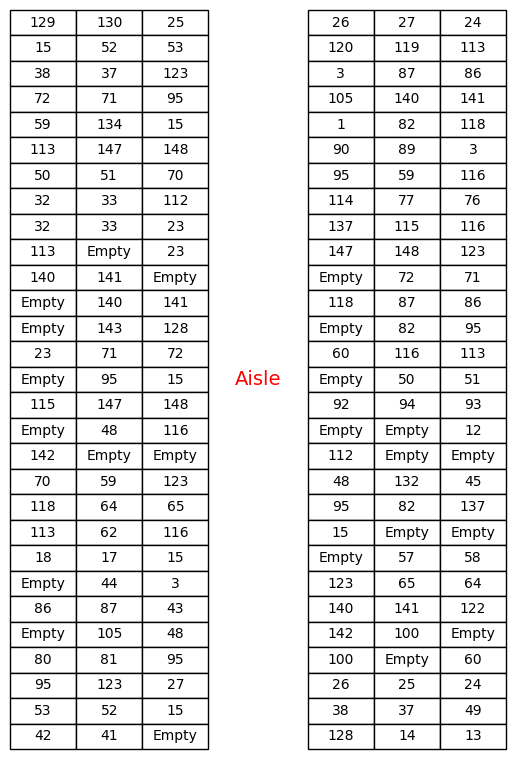

In [110]:

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if post_processing_assignments[(i,j,k)] == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['type']==2 :
                        colors1[i-1][j-1] = '#800080'
                        colors1[i-1][j-2] = '#800080'
                        colors1[i][j-1] = '#800080'
                        colors1[i][j-2] = '#800080'
                elif j>4:
                    data2[i-1][j-5] = k
                    if Passengers[k]['type']==2:
                        colors2[i-1][j-5] = '#800080'
                        colors2[i-1][j-6] = '#800080'
                        colors2[i][j-5] = '#800080'
                        colors2[i][j-6] = '#800080'

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

In [111]:
def recalculer_barycentre(assignations, nombre_lignes, nombre_colonnes):
    somme_x = somme_y = somme_masse = 0

    for i in range(1, nombre_lignes + 1):
        for j in range(1, nombre_colonnes + 1):
            for pass_id, presence in assignations.items():
                if presence == 1:
                    # Supposons que `masse_passager` est disponible
                    if Passengers[pass_id]['type']==0:
                        masse_passager = weight_f
                    elif Passengers[pass_id]['type']==1:
                        masse_passager = weight_m
                    elif Passengers[pass_id]['type']==2:
                        masse_passager = weight_d
                    somme_x += i * masse_passager
                    somme_y += j * masse_passager
                    somme_masse += masse_passager

    barycentre_x = somme_x / somme_masse
    barycentre_y = somme_y / somme_masse
    return barycentre_x, barycentre_y

recalculer_barycentre(post_processing_assignments, number_of_rows, number_of_columns)

KeyError: (1, 1, 129)

In [ ]:
i_m = quicksum([weight_m * i* post_processing_assignments[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

i_f = quicksum([weight_f * i* post_processing_assignments[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

i_d = quicksum([weight_d * i* post_processing_assignments[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

i_bary = (i_m + i_f +i_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

print(i_bary)

j_m = quicksum([weight_m * j* post_processing_assignments[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

j_f = quicksum([weight_f * j* post_processing_assignments[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

j_d = quicksum([weight_d * j* post_processing_assignments[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

j_bary = (j_m + j_f + j_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

print(j_bary)

14.439425918108908
3.996200928661883
